In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

Loading BokehJS ...

### GPU
指定使用的 GPU 编号。  
`watch -n 1 nvidia-smi` 实时查看 GPU 的运行状态。 

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Data
通过`torchvision.datasets`下载`CIFAR-10`数据。其中包含10类图片，每类图片6000张。  
训练集：`train=True`  
测试集：`train=False`  
常用的还有`torchvision.datasets.ImageFolder()`，按文件夹取图片。  

`torchvision.transforms`可以对图片做处理。  
`trans` 对四种处理进行了组合，包括调节图片尺寸、随机水平翻转、随机中心切割、化为`Tensor`.

In [3]:
trans = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
])

In [4]:
train_dataset = dsets.CIFAR10(root='../dataset', train=True, transform=trans, download=True)
test_dataset = dsets.CIFAR10(root='../dataset', train=False, transform=trans, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

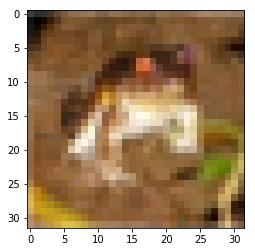

In [6]:
plt.imshow(train_dataset.data[0])

### Model
构造 Block，并用它作为单元构造 ResNet.

In [7]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

Residual 体现在最后 `return` 时，返回的是经过卷积操作的 `x` 加上原来的 `x`。  
但由于两者维度可能不相符(卷积的 `stride > 1` 会使得图像降维)，对 `x` 要进行 `downsample` 操作。  

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        residual = self.downsample(x) if self.downsample else x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.relu(x + residual)

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 16
        self.hidden_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1])
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.squeeze(x)
        return self.fc(x)
    def make_layer(self, block, out_channels, blocks_size, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                conv3x3(self.hidden_channels, out_channels, stride * 2),
                nn.BatchNorm2d(out_channels),
            )
        elif self.hidden_channels != out_channels:
            downsample = nn.Sequential(
                conv3x3(self.hidden_channels, out_channels, stride),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.hidden_channels, out_channels, stride, downsample))
        self.hidden_channels = out_channels
        for i in range(1, blocks_size):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

In [10]:
lrate = 0.001
epochs = 3

model = ResNet(ResidualBlock, [4,4,4]).cuda()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lrate)

网络层数越深，可覆盖的解空间越广，理论上的精度越高。但实际上层数适中时才能保证收敛性和精度。

In [11]:
model

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

注意：每次反向传播的时候都需要将参数的梯度归零。  
`optim.step()`则在每个`Variable`的`grad`都被计算出来后，更新每个`Variable`的数值

在每次训练中都用`train_loader`中的一个`batch`作为训练数据。  
`Tensor.cuda()` 每个 `batch` 在实际使用之前，都先移入 `GPU` 后进行计算。  

In [12]:
result = []
for e in range(epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.cuda()
        targets = targets.cuda()
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        if i%50==0:
            result.append(float(loss))
    
fig = figure()
fig.line(range(len(result)), result)
show(fig)

### Result

`re = torch.max(Tensor,dim)`, 返回的re为一个二维向量，其中`re[0]`为最大值的`Tensor`，re[1]为最大值对应的`index`

In [13]:
correct = 0
total = 0
for i, (inputs, targets) in enumerate(test_loader):
    targets = targets.cuda()
    inputs = inputs.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    total += len(outputs)
    correct += (preds == targets).sum()
accuracy = 100 * correct.double() / total
print('Accuracy of the model on the 10000 test images: %.2f %%' % (accuracy))

Accuracy of the model on the 10000 test images: 70.85 %


### Save Model

In [14]:
torch.save(model.state_dict(), 'resnet_cuda.pkl')